In [53]:
import librosa
from scipy.fftpack import fft
import IPython.display as ipd
import matplotlib.pyplot as plt
from librosa import display
import numpy as np
import soundfile as sf
import pandas as pd
import os, wave, glob
from tqdm import tqdm
import matplotlib.pyplot as plt

#supress warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/'CMPT 353'

/content/drive/.shortcut-targets-by-id/1gK9p0F1KMuXLhw2xfPvGR11GeVyByifY/CMPT 353


# Download and extract kaggle dataset


To get the dataset you either create an account on `https://www.kaggle.com/` and get kaggle username + key for instructions below or directly download dataset `https://www.kaggle.com/andrewmvd/covid19-cough-audio-classification` and extract files into a folder called `audiofiles`

In [ ]:
os.environ['KAGGLE_USERNAME'] = "Kaggle_username" # username from the json file
os.environ['KAGGLE_KEY'] = "Kaggle_key" # key from the json file
!kaggle datasets download -d andrewmvd/covid19-cough-audio-classification

100% 1.24G/1.24G [00:16<00:00, 110MB/s]



In [ ]:
#make a new folder to extract dataset to
mkdir audiofiles

In [ ]:
!unzip \*.zip -d audiofiles

# Dataset

In [ ]:
df = pd.read_csv('./audiofiles/metadata_compiled.csv')
df

,uuid,datetime,cough_detected,SNR,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,status,quality_1,cough_type_1,dyspnea_1,wheezing_1,stridor_1,choking_1,congestion_1,nothing_1,diagnosis_1,severity_1,quality_2,cough_type_2,dyspnea_2,wheezing_2,stridor_2,choking_2,congestion_2,nothing_2,diagnosis_2,severity_2,quality_3,cough_type_3,dyspnea_3,wheezing_3,stridor_3,choking_3,congestion_3,nothing_3,diagnosis_3,severity_3,quality_4,cough_type_4,dyspnea_4,wheezing_4,stridor_4,choking_4,congestion_4,nothing_4,diagnosis_4,severity_4
0,00014dcc-0f06-4c27-8c7b-737b18a2cf4c,2020-11-25T18:58:50.488301+00:00,0.0155,7.326171,48.9,2.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,2020-04-13T21:30:59.801831+00:00,0.9609,16.151433,31.3,34.8,15.0,male,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0007c6f1-5441-40e6-9aaf-a761d8f2da3b,2020-10-18T15:38:38.205870+00:00,0.1643,16.217201,NaN,NaN,46.0,female,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,2020-04-12T04:02:18.159383+00:00,0.9301,20.146058,40.0,-75.1,34.0,male,True,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0012c608-33d0-4ef7-bde3-75a0b1a0024e,2020-04-15T01:03:59.029326+00:00,0.0482,0.000000,-16.5,-71.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27545,fff30afc-db62-4408-a585-07ca9a254fcc,2020-11-05T08:26:04.219206+00:00,0.9698,11.109221,40.7,29.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27546,fff3ff61-2387-4139-938b-539db01e6be5,2020-06-28T21:28:21.530881+00:00,0.5257,43.932829,51.6,-0.2,NaN,female,False,False,symptomatic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27547,fff474bf-39a4-4a61-8348-6b992fb5e439,2020-04-10T05:10:36.787070+00:00,0.1945,27.702036,-39.0,-68.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27548,fffaa9f8-4db0-46c5-90fb-93b7b014b55d,2020-04-13T18:58:26.954663+00:00,0.0243,8.825849,41.0,28.8,50.0,male,True,True,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data filteration

Drop files with empty status; and focus only on uuid and status

In [ ]:
Covid_data = pd.DataFrame()
Covid_data['uuid'] = df['uuid']
Covid_data['status'] = df['status']
Covid_data = Covid_data.dropna()

Drop cases with symptomatic diagnosis (We will be only focusing on Healthy vs COVID-19 data)

In [ ]:
# This is should drop approx 3000 cases
Covid_data = Covid_data[(Covid_data['status'] != 'symptomatic')]

Since after droping Symptomatic cases, The number of healthy cases is much larger than Covid;
Remove excessive Healthy records to prevent healthy data empowering priorized covid-19 data

In [ ]:
df = Covid_data[Covid_data['status']=="healthy"]
remove_n = 4000
drop_indices = np.random.choice(df.index, remove_n, replace=False)
df_subset = df.drop(drop_indices)
df_subset

,uuid,status
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,healthy
5,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,healthy
8,001e2f19-d81c-4029-b33c-d2db56b23a4a,healthy
10,0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952,healthy
13,002d28bc-7806-4dfb-9c9b-afa8cb623cac,healthy
...,...,...
27534,ffd18a56-096d-40fc-9862-e5c5a8ca1fcd,healthy
27535,ffd42893-4119-4855-9aad-c67d8d392cc1,healthy
27538,ffdf80c2-be81-4fc9-9484-a72223cfc87d,healthy
27543,ffeea120-92a4-40f9-b692-c3865c7a983f,healthy


Remove 8479 randomly chosen healthy data

In [ ]:
Covid_data  = pd.concat([Covid_data, df_subset])
Covid_data = Covid_data.drop_duplicates(keep=False)

Remove undesired audio file format (.ogg)

In [ ]:
remove_audio_filesname =[]
for i,file in tqdm(enumerate(os.listdir("./audiofiles"))):
    if file.endswith(".ogg"):
        file = file.split(".")
        remove_audio_filesname.append(file[0])

55101it [00:00, 1576694.78it/s]


In [ ]:
for file_name in tqdm(remove_audio_filesname):
    Covid_data = Covid_data[Covid_data.uuid !=file_name]

100%|██████████| 1565/1565 [00:01<00:00, 870.66it/s]


In [ ]:
Covid_data

,uuid,status
0,0007c6f1-5441-40e6-9aaf-a761d8f2da3b,healthy
1,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,healthy
2,001d8e33-a4af-4edb-98ba-b03f891d9a6c,COVID-19
3,00291cce-36a0-4a29-9e2d-c1d96ca17242,healthy
4,00357712-dd5a-4c0a-90a4-39f1f4b9d5fd,COVID-19
...,...,...
4877,ffbd7a5d-6e84-4592-8c11-f3854c6f7d6f,healthy
4878,ffe0658f-bade-4654-ad79-40a468aabb03,COVID-19
4879,ffe5e2a4-ef67-464d-b1cd-b0e321f6a2dd,healthy
4880,ffedc843-bfc2-4ad6-a749-2bc86bdac84a,healthy


# Understanding Audio Data Analysis

Use the first file from covid data to help us understand more about the data and features we will be working on 

Source: https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html

In [51]:
# load the file into librosa to get numeric data array and sampling rate
arr, sr = librosa.load('./audiofiles/'+ Covid_data['uuid'][0] +'.webm', sr=None)

In [55]:
arr, sr

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 48000)

Plot wave form of the audio file

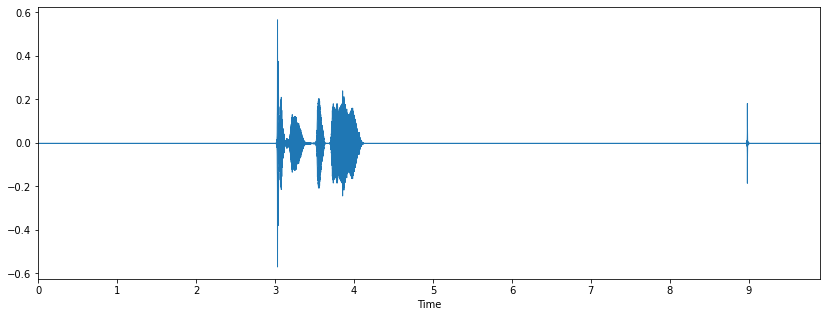

In [56]:
%matplotlib inline
plt.figure(figsize=(14, 5))
librosa.display.waveplot(arr, sr=sr)
#plt.savefig('wave.png')

Spectogram denoting the intensity of the audio

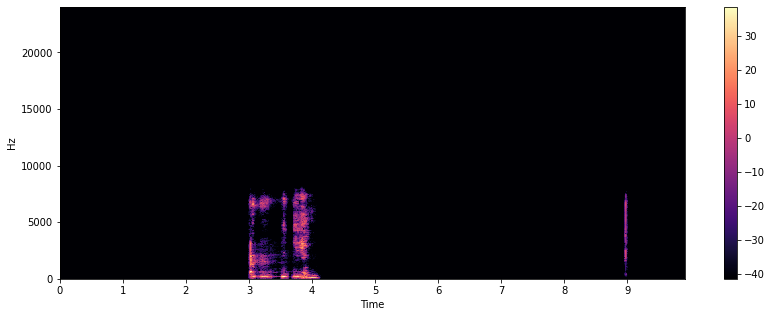

In [61]:
#time vs frequency graph
X = librosa.stft(arr)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
#plt.savefig('spec.png')

If we transform the graph by taking it's log and plot it, we can see the accurate intensity

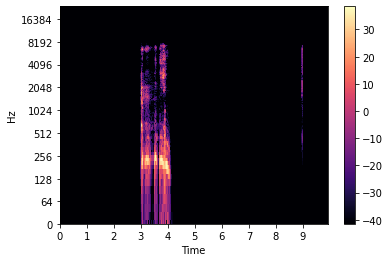

In [62]:
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
#plt.savefig('spec2.png')

Mel-Frequency Cepstral Coefficients(MFCCs): characteristics of the audio file

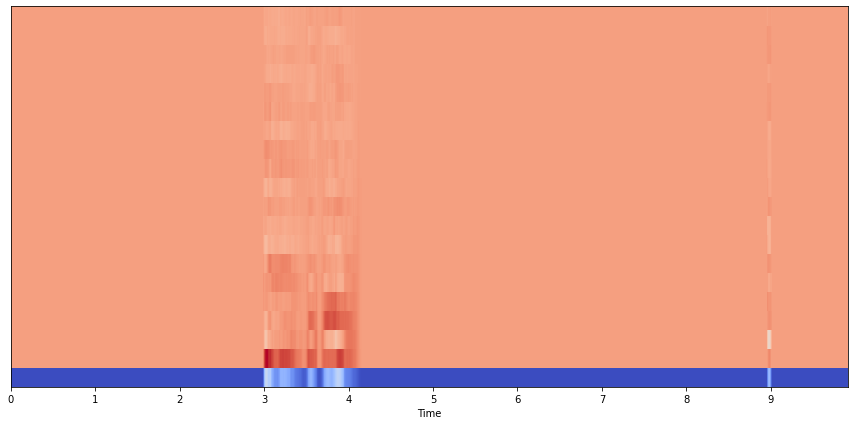

In [66]:
mfccs = librosa.feature.mfcc(arr, sr=sr)
#Displaying  the MFCCs:
plt.figure(figsize=(15, 7))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
#plt.savefig('mfcc.png')

Chroma Feature: energy of each pitch class

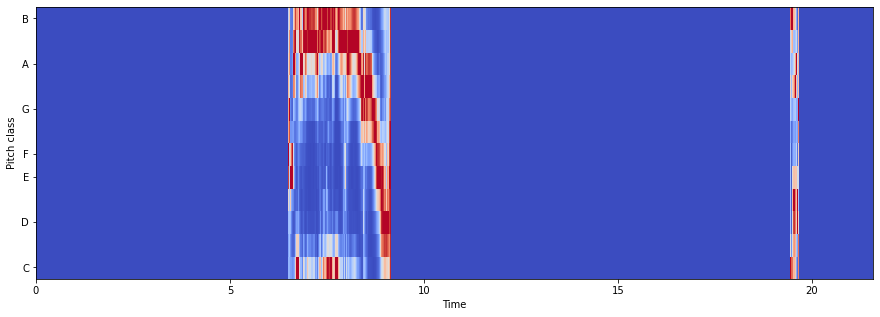

In [100]:
chromagram = librosa.feature.chroma_stft(arr, sr=sr)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.savefig('cstft.png')

Spectral Centroid: frequency the energy of a spectrum is centered upon

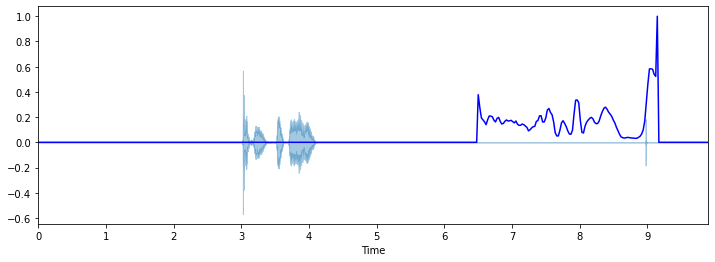

In [73]:
spectral_centroids = librosa.feature.spectral_centroid(arr, sr=sr)[0]
# Computing the time variable for visualization
plt.figure(figsize=(12, 4))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
    
#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(arr, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='b')
#plt.savefig('specc_cent.png')

Spectral Bandwidth : the width of the band of light at one-half the peak maximum (or full width at half maximum

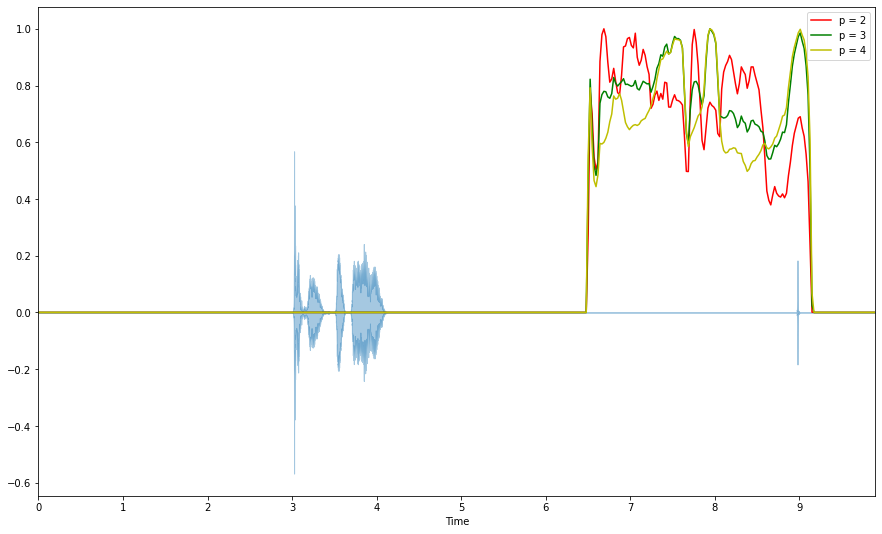

In [97]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(arr+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(arr+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(arr+0.01, sr=sr, p=4)[0]
plt.figure(figsize=(15, 9))
librosa.display.waveplot(arr, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))
#plt.savefig('spec_bw.png')

Spectral Rolloff: the frequency at which high frequencies decline to 0

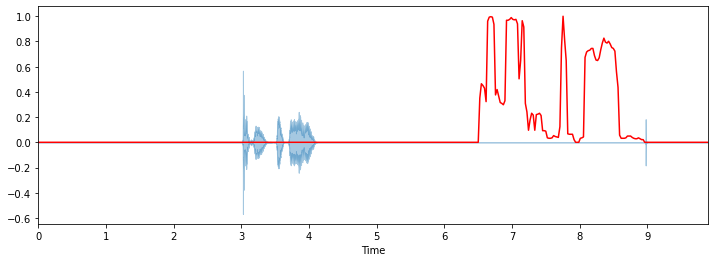

In [77]:
spectral_rolloff = librosa.feature.spectral_rolloff(arr+0.01, sr=sr)[0]
plt.figure(figsize=(12, 4))
librosa.display.waveplot(arr, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')
#plt.savefig('rolloff.png')

Zero Crossing Rate: No of times audio signal is crossing the zero axis

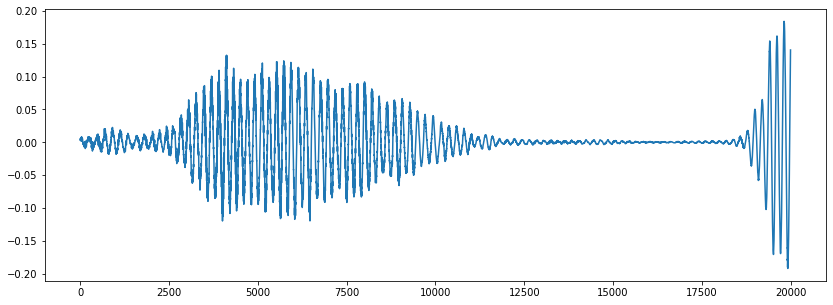

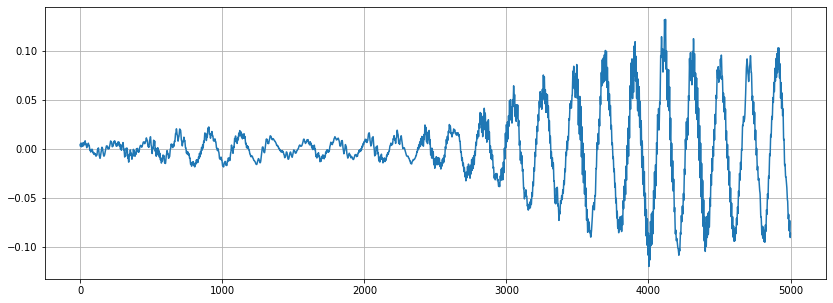

In [96]:
n0 = 150000
n1 = 170000
plt.figure(figsize=(14, 5))
plt.plot(arr[n0:n1])
n0 = 150000
n1 = 155000
plt.figure(figsize=(14, 5))
plt.plot(arr[n0:n1])
plt.grid()
#plt.savefig('zcr.png')

# Data wrangling and transformation

In [ ]:
# convert audio files into numeric array data
def get_audiovalue(x):
  try:
    arr, sr = librosa.load('./audiofiles/'+ x +'.webm', sr=None)
    return arr
  except:
    return None      

Split dataframe into 10 partitions for easier and faster processing; approximately 488 files in each partition

In [ ]:
dfs = np.array_split(Covid_data, 10)

Runtime: 1hr+ approx. 

In [42]:
for i in tqdm(range(10)):
  dfs[i]['audio_data'] = dfs[i]['uuid'].apply(get_audiovalue)

100%|██████████| 10/10 [1:13:17<00:00, 439.77s/it]


# Optional: Save processed data into multiple `.ftr` files that we can read later to skip above steps

Save processed dataframes to feather compressed files

In [ ]:
# create a new folder to save files to
mkdir processed_dataset

In [ ]:
for i in tqdm(range(10)):
  dfs[i] = df[i].reset_index(drop=True)
  dfs[i].to_feather('./processed_dataset/df'+ str(i) +'.ftr')

Read processed dataframes from saved `.ftr` files

In [ ]:
Covid_data = pd.DataFrame()

In [ ]:
for filename in tqdm(glob.glob(os.path.join('', './processed_dataset/*.ftr'))):
    df = pd.read_feather(filename)
    Covid_data = pd.concat([Covid_data, df])

100%|██████████| 10/10 [01:02<00:00,  6.29s/it]


# If you didn't save processed dfs to `.ftr` files 
>run the code below

In [44]:
# concatenate all processed dfs back to Covid_data
Covid_data = pd.concat([dfs[1], dfs[2], dfs[3], dfs[4], dfs[5], dfs[6], dfs[7], dfs[8], dfs[9]])

# Feature Extraction

In [45]:
Covid_data = Covid_data.reset_index(drop=True)
Covid_data

,uuid,status,audio_data
0,1815558e-7a10-406f-af9a-4c9c0ac627ce,healthy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,182246b0-9f77-4c40-976e-3c9342619819,COVID-19,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,18320fab-de49-42f7-8d76-f8caebe05ac4,healthy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1853c64d-a058-471d-8409-84fd2afb5edd,COVID-19,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1873c115-7482-4c2c-b810-03945cb4ea4f,healthy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
4388,ffbd7a5d-6e84-4592-8c11-f3854c6f7d6f,healthy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4389,ffe0658f-bade-4654-ad79-40a468aabb03,COVID-19,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4390,ffe5e2a4-ef67-464d-b1cd-b0e321f6a2dd,healthy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4391,ffedc843-bfc2-4ad6-a749-2bc86bdac84a,healthy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


we extract audio features such as mfcc, mel, cstft from processed audio file data to train our machine learning model

In [46]:
#default sampling rate
sr = 48000

In [47]:
#create lists to store mean feature value
mfcc = []
mel = []
cstft = []
rms = []
spec_cent = []
spec_bw = []
rolloff = []
zcr = []

In [48]:
def extract_mfcc(x):
  mfcc.append(np.mean(librosa.feature.mfcc(x, sr=sr)))
def extract_mel(x):
  mel.append(np.mean(librosa.feature.melspectrogram(x, sr=sr)))
def extract_cstft(x):
  cstft.append(np.mean(librosa.feature.chroma_stft(x, sr=sr)))
def extract_rms(x):
  rms.append(np.mean(librosa.feature.rms(x)))
def extract_spec_cent(x):
  spec_cent.append(np.mean(librosa.feature.spectral_centroid(x, sr=sr)))
def extract_spec_bw(x):
  spec_bw.append(np.mean(librosa.feature.spectral_bandwidth(x, sr=sr)))
def extract_rolloff(x):
  rolloff.append(np.mean(librosa.feature.spectral_rolloff(x, sr=sr)))
def extract_zcr(x):  
  zcr.append(np.mean(librosa.feature.zero_crossing_rate(x)))


Using list map func for faster runtime and optimised performance

In [ ]:
# mfccs : Mel-Frequency Cepstral Coefficients
# models the characteristics of the human voice. 
x = list(map(extract_mfcc, Covid_data['audio_data']))

In [ ]:
# mel : Mel-scaled spectrogram
# Denotes the power spectrum of an audio file
x = list(map(extract_mel, Covid_data['audio_data']))

In [ ]:
# cstft : Chroma feature
# Describe a similarity measure between music pieces such as C, C#, D
x = list(map(extract_cstft, Covid_data['audio_data']))

In [ ]:
# rms : Root Mean Square
# Compute RMS value for each frame of audio data
x = list(map(extract_rms, Covid_data['audio_data']))

In [ ]:
# spec_cent : Spectral Centroid
# Computes the spectral centroid for each frame of audio data
x = list(map(extract_spec_cent, Covid_data['audio_data']))

In [ ]:
# spec_bw : spectral bandwidth
# computes the order-p spectral bandwidth
x = list(map(extract_spec_bw, Covid_data['audio_data']))

In [ ]:
# rolloff : rolloff frequency
# Computes the rolloff frequency for each frame of audio data
x = list(map(extract_rolloff, Covid_data['audio_data']))

In [ ]:
# zcr : zero crossing rate
# Calculate the number of zero-crossing of audio data
x = list(map(extract_zcr, Covid_data['audio_data']))

In [ ]:
#  Convert feature lists to dataframes
mfcc_df = pd.DataFrame(mfcc)
mel_df = pd.DataFrame(mel)
cstft_df = pd.DataFrame(cstft)
rms_df = pd.DataFrame(rms)
spec_cent_df = pd.DataFrame(spec_cent)
spec_bw_df = pd.DataFrame(spec_bw)
rolloff_df = pd.DataFrame(rolloff)
zcr_df = pd.DataFrame(zcr)

# Optional: Save extracted features dataframes

use pickle file compression to store the features

In [ ]:
# save converted dataframes as pickle file
mfcc_df.to_pickle('./processed_dataset/mfcc.pkl')
mel_df.to_pickle('./processed_dataset/mel.pkl')
cstft_df = pd.to_pickle('./processed_dataset/cstft.pkl')
rms_df = pd.to_pickle('./processed_dataset/rms.pkl')
spec_cent_df = pd.to_pickle('./processed_dataset/spec_cent.pkl')
spec_bw_df = pd.to_pickle('./processed_dataset/spec_bw.pkl')
rolloff_df = pd.to_pickle('./processed_dataset/rolloff.pkl')
zcr_df = pd.to_pickle('./processed_dataset/zcr.pkl')

In [ ]:
# Retrive previouly saved feature files
mfcc_df = pd.read_pickle('./processed_dataset/mfcc.pkl')
mel_df = pd.read_pickle('./processed_dataset/mel.pkl')
cstft_df = pd.read_pickle('./processed_dataset/cstft.pkl')
rms_df = pd.read_pickle('./processed_dataset/rms.pkl')
spec_cent_df = pd.read_pickle('./processed_dataset/spec_cent.pkl')
spec_bw_df = pd.read_pickle('./processed_dataset/spec_bw.pkl')
rolloff_df = pd.read_pickle('./processed_dataset/rolloff.pkl')
zcr_df = pd.read_pickle('./processed_dataset/zcr.pkl')

# Import extracted features to Dataframe

In [ ]:
Covid_data['mfcc'] = mfcc_df
Covid_data['mel'] = mel_df
Covid_data['cstft'] = cstft_df
Covid_data['rms'] = rms_df
Covid_data['spec_cent'] = spec_cent_df
Covid_data['spec_bw'] = spec_bw_df
Covid_data['rolloff'] = rolloff_df
Covid_data['zcr'] = zcr_df

In [ ]:
Covid_data

,uuid,status,audio_data,mfcc,mel,cstft,rms,spec_cent,spec_bw,rolloff,zcr
0,00039425-7f3a-42aa-ac13-834aaa2b6b92,healthy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-27.178593,0.279080,0.098792,0.010751,587.720727,639.077238,1303.784419,0.011036
1,001d8e33-a4af-4edb-98ba-b03f891d9a6c,COVID-19,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-27.324879,0.036435,0.342296,0.008710,2014.876104,2245.589843,3302.451686,0.055397
2,001e2f19-d81c-4029-b33c-d2db56b23a4a,healthy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-25.482893,0.180400,0.094991,0.007325,373.992608,469.011225,738.896648,0.007722
3,0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952,healthy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-26.161425,0.345826,0.208515,0.016831,2508.176848,1763.962534,4512.768447,0.020139
4,0029d048-898a-4c70-89c7-0815cdcf7391,symptomatic,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-24.530035,0.661929,0.487353,0.021667,5976.977181,5931.116308,13009.082137,0.080433
...,...,...,...,...,...,...,...,...,...,...,...
7237,ffe0658f-bade-4654-ad79-40a468aabb03,COVID-19,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-19.133991,6.157269,0.576246,0.089692,4298.438792,3811.522505,8622.093226,0.079091
7238,ffe13fcf-c5c2-4a6a-a9fc-e010f4f033c1,symptomatic,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-25.563425,0.492984,0.479262,0.025475,3517.708708,3660.802227,7082.212056,0.079107
7239,ffeea120-92a4-40f9-b692-c3865c7a983f,healthy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-24.647821,0.317688,0.522890,0.014490,4992.935139,5168.046111,11127.090026,0.095019
7240,fff13fa2-a725-49ef-812a-39c6cedda33d,healthy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-28.649740,0.123611,0.399429,0.013570,4786.136244,4635.211785,9774.749395,0.096035


# Training ML model

In [ ]:
X = Covid_data.iloc[:,[3,4,5,6,7,8,9,10]].values
y = Covid_data.iloc[:,1].values

In [ ]:
X, y

(array([[-2.71785927e+01,  1.27000000e+03,  9.87921134e-02, ...,
          6.39077238e+02,  1.30378442e+03,  1.10355822e-02],
        [-2.73248787e+01,  5.84000000e+02,  3.42295915e-01, ...,
          2.24558984e+03,  3.30245169e+03,  5.53974352e-02],
        [-2.54828930e+01,  9.95000000e+02,  9.49907899e-02, ...,
          4.69011225e+02,  7.38896648e+02,  7.72193610e-03],
        ...,
        [-1.91339912e+01,  4.76500000e+03,  5.76245964e-01, ...,
          3.81152251e+03,  8.62209323e+03,  7.90906512e-02],
        [-2.46478214e+01,  1.37900000e+03,  5.22890091e-01, ...,
          5.16804611e+03,  1.11270900e+04,  9.50191890e-02],
        [-2.86497402e+01,  8.42000000e+02,  3.99429470e-01, ...,
          4.63521179e+03,  9.77474939e+03,  9.60347778e-02]]),
 array([0, 1, 0, ..., 1, 0, 0], dtype=int64))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X,y)

In [43]:
scaler = StandardScaler()
scaler.fit(X_train)
x_train_scaled = scaler.transform(X_train)
x_val_scaled = scaler.transform(X_val)

pca = PCA().fit(X_train)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.show()
plt.savefig('MLVar.png')

NameError: ignored

In [ ]:
k_range = list(range(3,21))
param_grid = {
    'n_neighbors': k_range,
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

model = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, n_jobs=-1, scoring='accuracy')
model.fit(x_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [ ]:
# Predicting the test results
y_predict=model.predict(x_val_scaled)

# Classification results on test set
print("Training Accuracy: {:.2f}".format(model.score(x_train_scaled, y_train)))
accuracy = metrics.accuracy_score(y_val, y_predict)
print("Validation Accuracy: {:.2f}".format(accuracy))

cm=confusion_matrix(y_val,y_predict)
print('Confusion Matrix: \n', cm)
print(classification_report(y_val,y_predict))

Accuracy: 0.77
Confusion Matrix: 
 [[927  13]
 [261   7]]
              precision    recall  f1-score   support

     healthy       0.78      0.99      0.87       940
    COVID-19       0.35      0.03      0.05       268

    accuracy                           0.77      1208
   macro avg       0.57      0.51      0.46      1208
weighted avg       0.68      0.77      0.69      1208

